In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
from src.datareader import datareader as dr

<h3>Initialize Data Readers</h3>

In [2]:
# ufs_data_reader = dr.getDataReader(datasource='UFS', filename="experiments/phase_1/baseline/atm_monthly.zarr", model='atm')
# era5_data_reader = dr.getDataReader(datasource='ERA5', filename="1959-2022-6h-1440x721.zarr/") # <-- 6hr, high resolution data
# Read FSB baseline 
ufs_data_reader = dr.getDataReader(datasource='UFS', filename="experiments/phase_1/baseline/atm_monthly.zarr", model='atm')
era5_data_reader = dr.getDataReader(datasource='ERA5') # <-- 6hr, lower-resolution data by default

Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/baseline/atm_monthly.zarr
UFS dataset loaded.
Standardizing coordinate system
Dataset ready.
No filename provided; deferring to default
Reading data from gs://gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr/
ERA5 dataset loaded.
Standardizing coordinate system
Sorting lat descending
Dataset ready.


In [ ]:
# ufs_data_reader.describe()

In [ ]:
# era5_data_reader.describe()

<h3>Retrieve DataSets</h3>

In [3]:
time_range = ("1994-05-01","2021-05-31T23")

In [4]:
# Retrieve a UFS dataset
# The complete dataset is preserved after retrieval
ufs_ds = ufs_data_reader.retrieve(
    var = 'tmpsfc',
    time=time_range,
    ens_avg=True
) 

Slicing by init
Taking Ensemble Average


In [ ]:
# ufs_ds.tmpsfc

In [5]:
# Retrieve an ERA5 dataset 
# The complete dataset is preserved after retrieval
era5_ds = era5_data_reader.retrieve(
    var='sea_surface_temperature',
    time=time_range
)

Slicing by time


<h3>Calculate Nino3.4 Index for UFS and ERA5</h3>

In [6]:
from climpred import HindcastEnsemble
import climpred

In [7]:
fcstnino34=ufs_ds['tmpsfc'].sel(lat=slice(5,-5),lon=slice(190,240)).mean(['lat','lon'])
verifnino34=era5_ds['sea_surface_temperature'].sel(lat=slice(5,-5),lon=slice(190,240)).mean(['lat','lon'])

<h3> Resample ERA5 to monthly means</h3>

In [8]:
verifnino34=verifnino34.resample(time='MS').mean()

<h3>Calculate and plot Nino3.4 RMSE</h3>

In [9]:
fcst = HindcastEnsemble(fcstnino34.load())
fcst = fcst.add_observations(verifnino34.load().rename('tmpsfc'))
fcst = fcst.remove_seasonality("month")
result_rms = fcst.verify(metric='rmse',comparison='e2o',dim='init',alignment='maximize',groupby='month')

In [10]:
skill_rms = np.empty([len(result_rms.lead), 12])
skill_rms.fill(np.nan)
skill_rms[:,4] = result_rms['tmpsfc'][0,:]
skill_rms[:,11] = result_rms['tmpsfc'][1,:]

Text(0, 0.5, 'Lead Time (Months)')

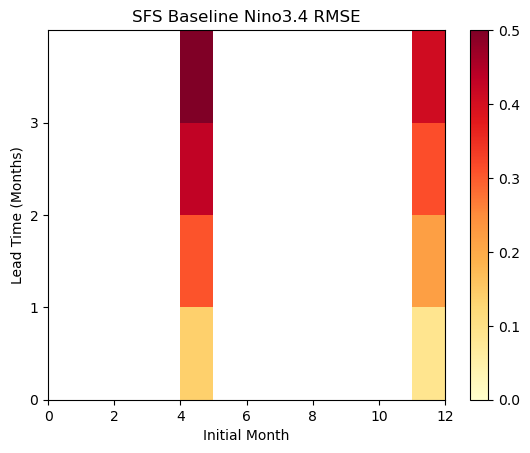

In [11]:
fig,ax = plt.subplots()
pcm = ax.pcolormesh(skill_rms,cmap=plt.cm.YlOrRd,vmin=0.0,vmax=0.5)
fig.colorbar(pcm,ax = ax)
ax.set_yticks(np.arange(len(result_rms.lead)))
plt.title("SFS Baseline Nino3.4 RMSE")
plt.xlabel("Initial Month")
plt.ylabel("Lead Time (Months)")

Text(0, 0.5, 'RMSE')

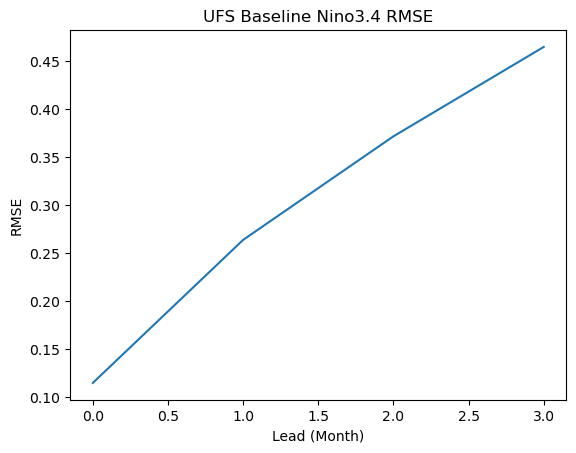

In [12]:
result_rms.tmpsfc.mean(dim='month').to_series().plot.line()
plt.title("UFS Baseline Nino3.4 RMSE")
plt.xlabel("Lead (Month)")
plt.ylabel("RMSE")

<h3>Compare with CPC ICs</h3>

In [13]:
# clean up data no longer needed
del ufs_data_reader, ufs_ds, fcstnino34

<h3>Retrieve DataSets</h3>

In [14]:
ufs_data_reader = dr.getDataReader(datasource='UFS', filename='experiments/phase_1/cpc_ics/atm_monthly.zarr',model='atm')

Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/cpc_ics/atm_monthly.zarr
UFS dataset loaded.
Standardizing coordinate system
Dataset ready.


In [15]:
ufs_ds = ufs_data_reader.retrieve(
    var = 'tmpsfc',
    time=time_range,
    ens_avg=True
)

Slicing by init
Taking Ensemble Average


<h3>Calculate Nino3.4 Index</h3> 

In [16]:
fcstnino34=ufs_ds['tmpsfc'].sel(lat=slice(5,-5),lon=slice(190,240)).mean(['lat','lon'])

<h3>Calculate and plot Nino3.4 RMSE</h3>

In [17]:
fcst = HindcastEnsemble(fcstnino34.load())
fcst = fcst.add_observations(verifnino34.load().rename('tmpsfc'))
fcst = fcst.remove_seasonality("month")
result_cpc_rms = fcst.verify(metric='rmse',comparison='e2o',dim='init',alignment='maximize',groupby='month')

In [18]:
skill_cpc_rms = np.empty([len(result_cpc_rms.lead), 12])
skill_cpc_rms.fill(np.nan)
skill_cpc_rms[:,4] = result_cpc_rms['tmpsfc'][0,:]
skill_cpc_rms[:,11] = result_cpc_rms['tmpsfc'][1,:]

Text(0, 0.5, 'Lead Time (Months)')

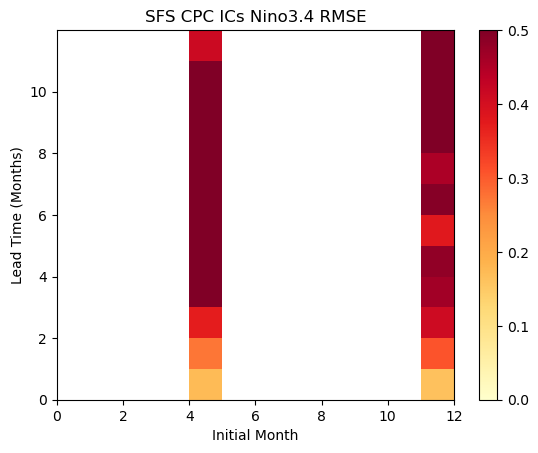

In [19]:
fig,ax = plt.subplots()
pcm = ax.pcolormesh(skill_cpc_rms,cmap=plt.cm.YlOrRd,vmin=0.0,vmax=0.5)
fig.colorbar(pcm,ax = ax)
ax.set_yticks(np.arange(0,12,2))
plt.title("SFS CPC ICs Nino3.4 RMSE")
plt.xlabel("Initial Month")
plt.ylabel("Lead Time (Months)")

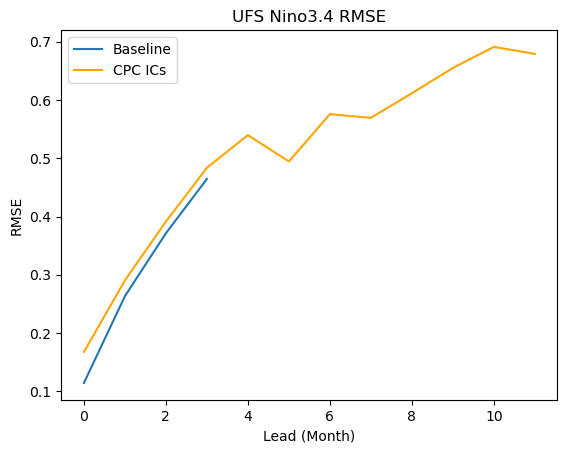

In [20]:
result_rms.tmpsfc.mean(dim='month').to_series().plot.line(label='Baseline')
result_cpc_rms.tmpsfc.mean(dim='month').to_series().plot.line(c='orange',label='CPC ICs')
plt.title("UFS Nino3.4 RMSE")
plt.xlabel("Lead (Month)")
plt.ylabel("RMSE")
plt.legend()